In [3]:
import pickle
import os
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler

In [4]:
# Path to subject S2's data
file_path = "../data/raw/WESAD/S2/S2.pkl"

# Load with correct encoding
with open(file_path, 'rb') as file:
    data = pickle.load(file, encoding='latin1')

# Check top-level keys
print("Top-level keys:", data.keys())

Top-level keys: dict_keys(['signal', 'label', 'subject'])


In [5]:
# Check available modalities
print("Signal keys:", data['signal'].keys())  # ['chest', 'wrist']

# Inspect shapes under chest signals
print("\n📦 Chest Signals:")
for key, value in data['signal']['chest'].items():
    print(f"{key}: {value.shape}")

# Inspect shapes under wrist signals
print("\n📦 Wrist Signals:")
for key, value in data['signal']['wrist'].items():
    print(f"{key}: {value.shape}")

# Label information
print("\n🎯 Labels shape:", data['label'].shape)
print("Unique labels:", set(data['label']))

Signal keys: dict_keys(['chest', 'wrist'])

📦 Chest Signals:
ACC: (4255300, 3)
ECG: (4255300, 1)
EMG: (4255300, 1)
EDA: (4255300, 1)
Temp: (4255300, 1)
Resp: (4255300, 1)

📦 Wrist Signals:
ACC: (194528, 3)
BVP: (389056, 1)
EDA: (24316, 1)
TEMP: (24316, 1)

🎯 Labels shape: (4255300,)
Unique labels: {np.int32(0), np.int32(1), np.int32(2), np.int32(3), np.int32(4), np.int32(6), np.int32(7)}


In [6]:
label_map = {
    0: "Baseline",
    1: "Stress",
    2: "Amusement",
    3: "Meditation",
    4: "Start",
    6: "Transition",
    7: "Instruction"
}

In [7]:
# Original label array
labels = data['label']  # shape (4255300,)

# Convert to a flat array if needed
labels = labels.flatten()

# Map to string labels
string_labels = np.vectorize(label_map.get)(labels)

# Now `string_labels` is an array like ['Baseline', 'Baseline', 'Stress', ...]

In [8]:
# Create a small DataFrame to inspect
df = pd.DataFrame({
    "Label Code": labels[:100],
    "Activity": string_labels[:100]
})

print(df.head())

   Label Code  Activity
0           0  Baseline
1           0  Baseline
2           0  Baseline
3           0  Baseline
4           0  Baseline


In [9]:
# Extract chest signals and labels
chest_signals = data['signal']['chest']
labels = data['label']

# Combine signals into a DataFrame
chest_df = pd.DataFrame({
    'ACC_X': chest_signals['ACC'][:, 0],
    'ACC_Y': chest_signals['ACC'][:, 1],
    'ACC_Z': chest_signals['ACC'][:, 2],
    'ECG': chest_signals['ECG'].flatten(),
    'EMG': chest_signals['EMG'].flatten(),
    'EDA': chest_signals['EDA'].flatten(),
    'Temp': chest_signals['Temp'].flatten(),
    'Resp': chest_signals['Resp'].flatten(),
    'Label Code': labels
})

# Apply mapping
chest_df['Activity'] = chest_df['Label Code'].map(label_map)

print(chest_df['Activity'].head())

0    Baseline
1    Baseline
2    Baseline
3    Baseline
4    Baseline
Name: Activity, dtype: object


In [10]:
print(chest_df.isna().sum())
print(chest_df.describe())

ACC_X         0
ACC_Y         0
ACC_Z         0
ECG           0
EMG           0
EDA           0
Temp          0
Resp          0
Label Code    0
Activity      0
dtype: int64
              ACC_X         ACC_Y         ACC_Z           ECG           EMG  \
count  4.255300e+06  4.255300e+06  4.255300e+06  4.255300e+06  4.255300e+06   
mean   7.538656e-01 -1.331884e-01 -4.226812e-01  1.212245e-03 -2.412918e-03   
std    1.751162e-01  6.417297e-02  3.002357e-01  1.540773e-01  1.165187e-02   
min    2.150000e-01 -6.600000e-01 -1.135400e+00 -1.499542e+00 -4.149628e-01   
25%    6.210001e-01 -1.498000e-01 -7.172000e-01 -6.797791e-02 -8.331299e-03   
50%    8.568000e-01 -1.256000e-01 -3.222000e-01  8.239746e-03 -1.602173e-03   
75%    8.922000e-01 -9.579998e-02 -2.098000e-01  4.435730e-02  3.982544e-03   
max    2.029800e+00  5.390000e-01  1.246800e+00  1.499313e+00  3.009796e-01   

                EDA          Temp          Resp    Label Code  
count  4.255300e+06  4.255300e+06  4.255300e+06  4.

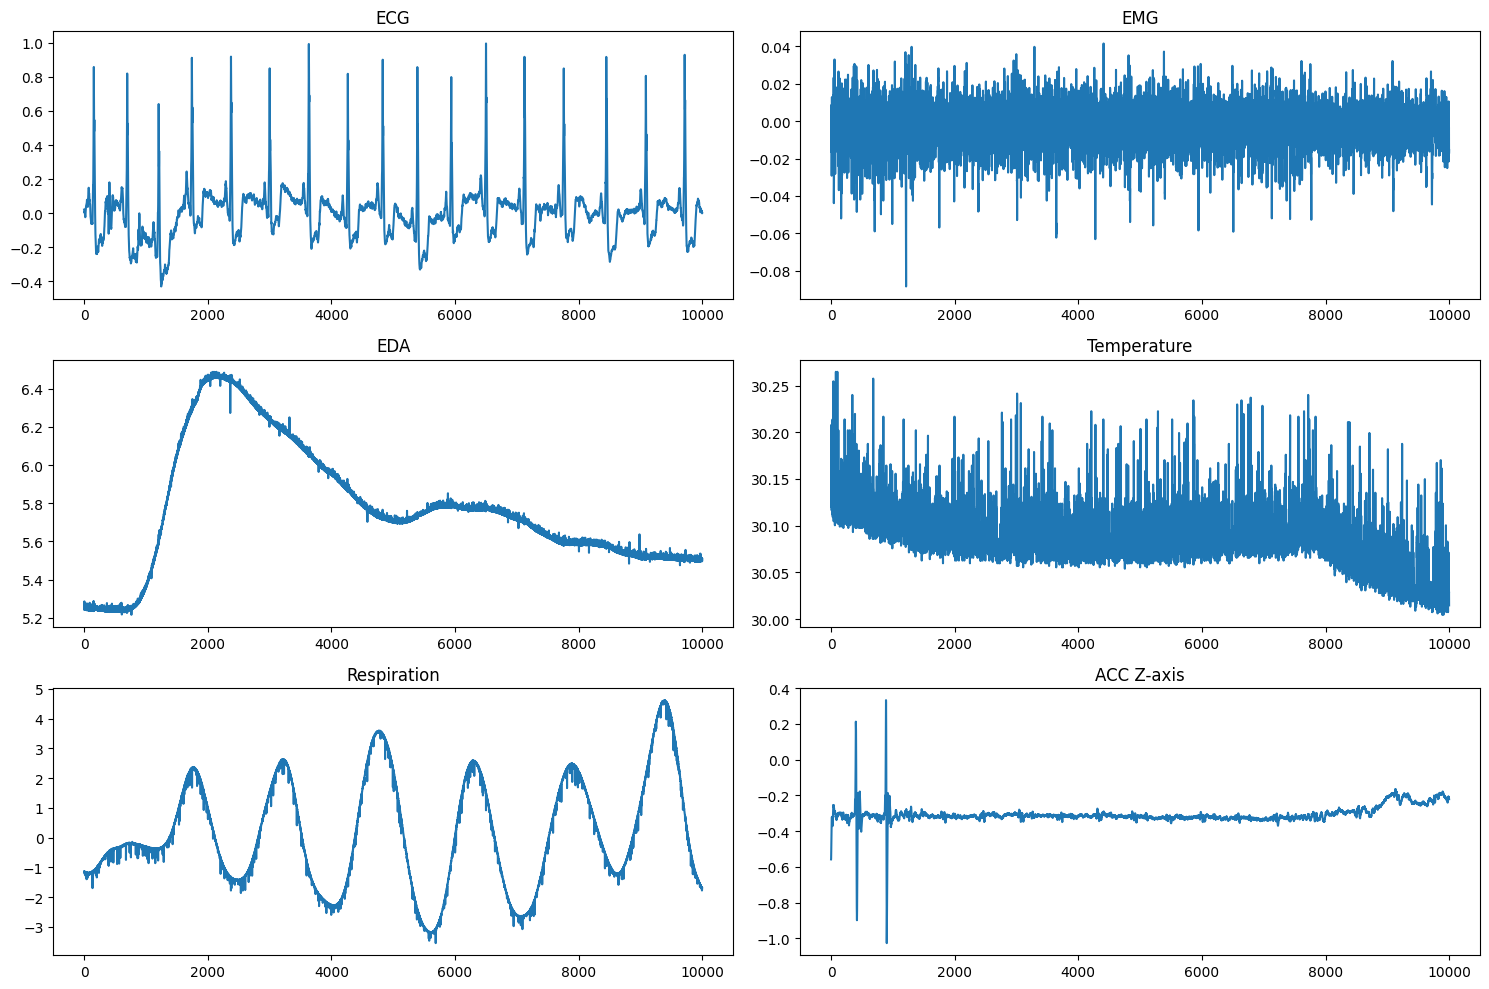

In [11]:
# Sample a slice of the chest data (first 10,000 rows)
sample = chest_df.iloc[:10000]

fig, axs = plt.subplots(3, 2, figsize=(15, 10))

axs[0, 0].plot(sample['ECG'])
axs[0, 0].set_title("ECG")

axs[0, 1].plot(sample['EMG'])
axs[0, 1].set_title("EMG")

axs[1, 0].plot(sample['EDA'])
axs[1, 0].set_title("EDA")

axs[1, 1].plot(sample['Temp'])
axs[1, 1].set_title("Temperature")

axs[2, 0].plot(sample['Resp'])
axs[2, 0].set_title("Respiration")

axs[2, 1].plot(sample['ACC_Z'])
axs[2, 1].set_title("ACC Z-axis")

plt.tight_layout()
plt.show()

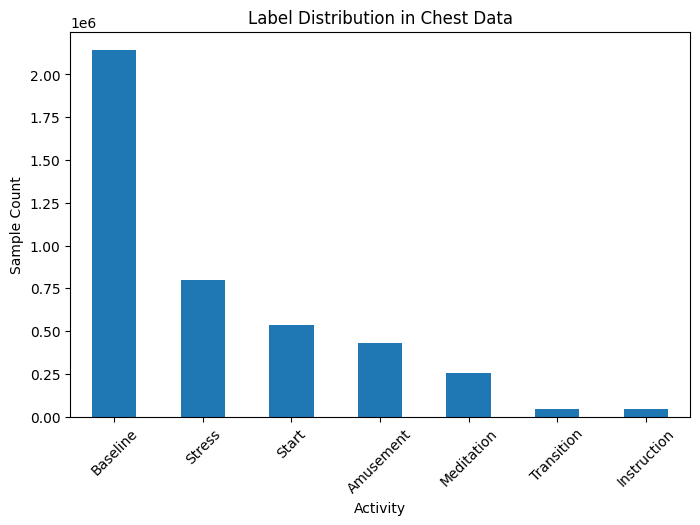

In [12]:
chest_df['Activity'].value_counts().plot(kind='bar', figsize=(8,5))
plt.title('Label Distribution in Chest Data')
plt.ylabel('Sample Count')
plt.xlabel('Activity')
plt.xticks(rotation=45)
plt.show()

In [13]:
# Define the classes to keep
valid_activities = ['Baseline', 'Stress', 'Amusement', 'Meditation']

# Filter chest_df to only include those rows
filtered_df = chest_df[chest_df['Activity'].isin(valid_activities)].copy()

# Reset index (optional but helpful)
filtered_df.reset_index(drop=True, inplace=True)

print(filtered_df['Activity'].value_counts())

Activity
Baseline      2142701
Stress         800800
Amusement      430500
Meditation     253400
Name: count, dtype: int64


In [15]:
# Choose signal columns only (exclude labels)
signal_columns = ['ACC_X', 'ACC_Y', 'ACC_Z', 'ECG', 'EMG', 'EDA', 'Temp', 'Resp']

# Fit and transform scaler
scaler = StandardScaler()
filtered_df[signal_columns] = scaler.fit_transform(filtered_df[signal_columns])

# joblib.dump(scaler, 'data/processed/chest_scaler.pkl')

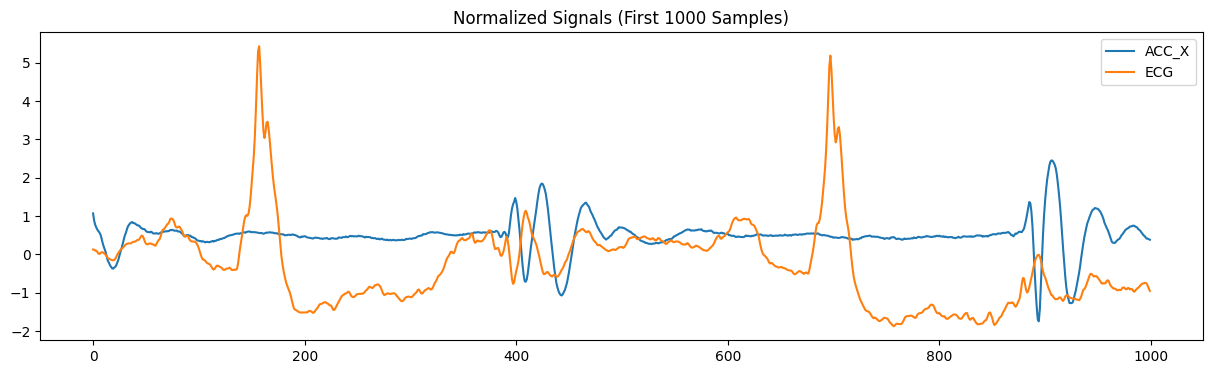

In [16]:
plt.figure(figsize=(15, 4))
plt.plot(filtered_df['ACC_X'][:1000], label='ACC_X')
plt.plot(filtered_df['ECG'][:1000], label='ECG')
plt.title("Normalized Signals (First 1000 Samples)")
plt.legend()
plt.show()

In [18]:
# Save the cleaned and normalized DataFrame
filtered_df.to_csv("../data/processed/chest_signals_normalized.csv", index=False)
